# Title: DM1590 Final Project Template

## Authors: Markus Brewitz, Linus Wallin, Saga Jonasson, Vilhelm Norström, Martin Ryberg Laude

---

### Background and motivation

News articles come in a variety of subjects and categories describing their field and relevance. Some of these have self-reported tags, but too many do not, or provide inaccurate tags. Tagging articles has the potential to help information-seekers to judge the relevance of articles and filter them by interest, especially in this day and age where information is so abundant it can be exhausting. In this project we set out to use machine learning to tag articles based on their titles, to aid the effort of searching for relevant information.

### Dataset

https://archive.ics.uci.edu/ml/datasets/News+Aggregator

This dataset contains tags along with corresponding news titles, which we use to train our models.

### Methodology

Describe what you are doing and how you are doing it.

---

##  Classification

### 1.1 Import data

In [2]:
import pandas as pd
import numpy as np
import nltk
#import spacy  # Might not be necessary, and proved to be annoying to deal with
#import re
import matplotlib.pyplot as plt
import mglearn
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
nltk.download('wordnet')
nltk.download('omw-1.4')

column_names = ["id", "title", "url", "publisher", "category", "story", "hostname", "timestamp"]
data = pd.read_csv('NewsAggregatorDataset/newsCorpora.csv',sep='\t',header=None, names=column_names)


[nltk_data] Downloading package wordnet to /Users/mrl/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/mrl/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


### 1.2 Vectorize data

By making use of the Bag of Words method (BoW) and its more advanced term frequency identifier 'variant' (Eh, we'll just change the description later) we can transform our data represented in documents of strings to feature vectors that we can machine learning methods on. To further improve the vectorization of our dataset we can also make use of n-Grams, as well as advanced methods of tokenization for the words in our dataset, such as normalizing the data through lemmatization.

In [3]:
# Delete duplicates
data[data['title'].duplicated(
    keep=False)].sort_values('title').head(8)
data = data.drop_duplicates('title')
corpus = data.title

# Splitting the data
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, data.category, train_size=0.7)  # TODO: Figure out a good ratio for training data vs test data

# Establishing stopwords
punc = ['.', ',', '"', "'", '?', '!', ':',
        ';', '(', ')', '[', ']', '{', '}', "%"]
stop_words = text.ENGLISH_STOP_WORDS.union(punc)

'''# regular expressions to be used in the TfidfVectorizer
regexp = re.compile('(?u)\\b\\w\\w+\\b')

# load spacy's English-language models
en_nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])'''

# Creates a tokenizer for stemming
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(document):
    return [stemmer.stem(word) for word in tokenizer.tokenize(document.lower())]


# Creates a tokenizer for lemmatization
lemmatizer = WordNetLemmatizer()

def lem_tokenize(document):
    return [lemmatizer.lemmatize(word) for word in tokenizer.tokenize(document.lower())]


'''# Creates a tokenizer for lemmatization (A bit unsure about why we do a couple of these things)
old_tokenizer = en_nlp.tokenizer
# replace the tokenizer with the preceding regexp
en_nlp.tokenizer = lambda string: old_tokenizer.tokens_from_list(
    regexp.findall(string))

def lem_tokenizer(document):
    doc_spacy = en_nlp(document)
    return [token.lemma_ for token in doc_spacy]'''

# TODO: Experiment with the min_df value to find what works best for it
vect = TfidfVectorizer(min_df=5, stop_words=stop_words,
                       tokenizer=lem_tokenize)

vec_matrix = vect.fit_transform(corpus) # Vectorizes the data


'''# Temporary code
vect_temp = vect = TfidfVectorizer(min_df=5, stop_words=stop_words,
                       tokenizer=tokenize)
vect_temp.fit(corpus_train)
X_train_temp = vect_temp.transform(corpus_train)'''


# Get feature names (title words)
feature_names = np.array(vect.get_feature_names_out())

# Transforms the training data using our vectorizer
vect.fit(corpus_train)
X_train = vect.transform(corpus_train)


/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
/opt/homebrew/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:516: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [4]:
''' Temporary cell for comparing the number of features from the different tokenization methods '''

vect3 = TfidfVectorizer(min_df=5, ngram_range=(1, 3), stop_words=stop_words)
vect3.fit(corpus_train)
X_train3 = vect3.transform(corpus_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_temp.shape: {}".format(X_train_temp.shape))
print("X_train3.shape: {}".format(X_train3.shape))

print("Vocabulary size: {}".format(len(vect3.vocabulary_)))

NameError: name 'stop_words' is not defined

### 1.3 Temporary cells

Experimental cells for min_df parameter and logistic regression

In [45]:
'''*** This cell is only there to visualize the min_df param. It has no real meaning outside of that scope ***'''
# Find maximum value for each of the features over the dataset
max_value = X_train.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

print("Features with lowest tfidf:\n{}".format(
    feature_names[sorted_by_tfidf[:20]]))

print("Features with highest tfidf: \n{}".format(
    feature_names[sorted_by_tfidf[-20:]]))


1000
['q' 'quarter' 'question' 'quit' 'rais' 'ralli' 'rank' 'rapper' 'rare'
 'rate' 'reach' 'read' 'readi' 'real' 'realiti' 'realli' 'reason' 'recal'
 'recap' 'receiv' 'record' 'red' 'reduc' 'regul' 'reject' 'releas'
 'remain' 'remov' 'renew' 'replac' 'report' 'research' 'respond' 'result'
 'retail' 'return' 'reveal' 'revenu' 'review' 'right' 'rihanna' 'rise'
 'risk' 'rival' 'road' 'robert' 'robin' 'rock' 'rogen' 'role' 'rolf'
 'roll' 'round' 'rule' 'rumor' 'run' 'russia' 'russian' 'ryan' 's'
 'safeti' 'said' 'sale' 'samsung' 'san' 'satellit' 'save' 'say' 'scandal'
 'scene' 'school' 'scienc' 'scientist' 'scott' 'screen' 'search' 'season'
 'second' 'secret' 'secur' 'seek' 'seen' 'selena' 'self' 'selfi' 'sell'
 'send' 'sequel' 'seri' 'servic' 'set' 'seth' 'settl' 'settlement' 'sex'
 'share' 'ship' 'shock' 'shoot' 'shop']
Features with lowest tfidf:
['vii' 'rogen' 'ignit' "'x" 'breast' 'fallon' 'peach' 'pitt' 'tab'
 'stream' 'hunger' 'xp' 'lg' 'virtual' 'york' 'playstat' 'dawn'
 'smartwat

In [6]:
''' ***DO NOT RUN THIS CELLBLOCK IF YOU CAN AVOID IT*** '''

# Searches for the best value for C for logistic regression
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters: ", grid.best_params_)

Best cross-validation score: 0.95
Best parameters:  {'C': 10}


In [7]:
'''
Best cross-validation score: 0.95
Best parameters:  {'C': 10}
'''

X_test = vect.transform(corpus_test) # Vectorizing the test data
print("Test score: {:.2f}".format(grid.score(X_test, y_test)))

Test score: 0.95


C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(
C:\Users\Markus\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:396: UserWarning: 

Best cross-validation score: 0.95
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}


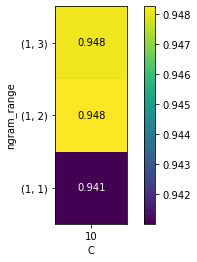

In [50]:
''' *** Cellblock for determining the best nGram value *** '''

pipe = make_pipeline(TfidfVectorizer(min_df=5, stop_words=stop_words, tokenizer=lem_tokenize), LogisticRegression(max_iter=1000))
# running the grid search takes a long time because of the
# relatively large grid and the inclusion of trigrams
param_grid = {"logisticregression__C": [10],
              "tfidfvectorizer__ngram_range": [(1, 1), (1, 2), (1, 3)]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(corpus_train, y_train)
print("Best cross-validation score: {:.2f}".format(grid.best_score_))
print("Best parameters:\n{}".format(grid.best_params_))

# extract scores from grid_search
scores = grid.cv_results_['mean_test_score'].reshape(-1, 3).T
# visualize heat map
heatmap = mglearn.tools.heatmap(
    scores, xlabel="C", ylabel="ngram_range", cmap="viridis", fmt="%.3f",
    xticklabels=param_grid['logisticregression__C'],
    yticklabels=param_grid['tfidfvectorizer__ngram_range'])
plt.colorbar(heatmap)

'''
Best cross-validation score: 0.95
Best parameters:
{'logisticregression__C': 10, 'tfidfvectorizer__ngram_range': (1, 2)}
(Bigram and trigram had the same results)
'''

## Clustering

### The elbow method

By using the elbow method we can identify how many clusters we should pick. We look at variance percentage as a function of the amount of clusters, as we should pick a cluster amount where adding more clusters wouldn't give better modeling. Plotting a graph of this results in the marginal gain dropping at some point(s) giving a downwards angle in the graph. 

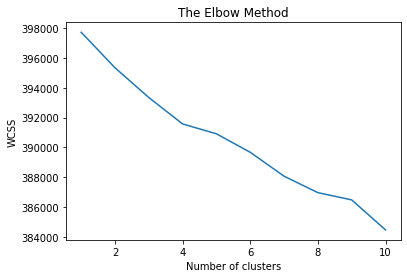

In [46]:

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++',
                    max_iter=300, n_init=10, random_state=0)
    kmeans.fit(vec_matrix)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


### 5 Clusters

In [5]:
kmeans = KMeans(n_clusters=5, n_init=20)
data = kmeans.fit(vec_matrix)

# We look at 5 the clusters generated by k-means.
common_words = kmeans.cluster_centers_.argsort()[:, -1:-26:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' +
          ', '.join(feature_names[word] for word in centroid))


0 : u, google, say, apple, video, stock, report, day, price, microsoft, facebook, million, review, sale, star, season, watch, deal, rate, china, market, rise, game, recall, amazon
1 : new, york, trailer, album, video, apple, release, feature, home, season, google, u, sale, report, watch, movie, launch, look, study, star, ceo, announces, htc, app, film
2 : year, old, high, rate, low, u, later, hit, sale, price, mortgage, million, new, fall, ago, time, gas, home, rise, lowest, say, china, inflation, end, profit
3 : kim, kardashian, kanye, west, wedding, kardashian's, west's, vogue, cover, photo, married, north, paris, jenner, dress, rob, honeymoon, baby, kanye's, khloe, look, kris, florence, racism, wed
4 : galaxy, samsung, s, tab, note, v, spec, mini, price, android, iphone, launch, feature, kitkat, comparison, zoom, release, review, htc, samsung's, t, k, guardian, date, india


In [1]:

centroids = kmeans.cluster_centers_

clusters = kmeans.predict(vec_matrix)
pca = PCA(n_components=2)
two_dim = pca.fit_transform(vec_matrix.todense())

scatter_x = two_dim[:, 0]  # first principle component
scatter_y = two_dim[:, 1]  # second principle component

plt.style.use('ggplot')

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

# color map for NUMBER_OF_CLUSTERS we have
cmap = {0: 'green', 1: 'blue', 2: 'red'}

# group by clusters and scatter plot every cluster
# with a colour and a label
for group in np.unique(clusters):
    ix = np.where(clusters == group)
    ax.scatter(scatter_x[ix], scatter_y[ix], c=cmap[group], label=group)

ax.legend()
plt.xlabel("PCA 0")
plt.ylabel("PCA 1")
plt.show()


NameError: name 'kmeans' is not defined

---
## Discussion

Reflect on your results, and how one might continue to improve them.

## Acknowledgments

For each group member, describe what they did.

## Final meme

Include here a meme describing your experience in this module.